# Tutorial: Branched differentiation trajectory of fly eye entennal disk

## 1. Preprocessing: Find your trajectories

Raw data used in this tutorial is available in GEO (GSE210749 and GSE141590). 

Processed loom files are available at: https://scope.aertslab.org/#/scenic-v2

A UCSC session is available at: http://genome.ucsc.edu/s/cbravo/SCENIC%2B_EAD

### 1a. Create your eGRN annData object

In this tutorial we are working with an unbranched trajectory, so we only have one trajectory. We will start by creating an anndata object with the GRN AUC values:

In [1]:
# Reset random seed
import numpy as np
np.random.seed(5)
# Set out directory
outDir='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/GRN_velocity/'

In [2]:
# Load data
dataDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/'
import dill
infile = open(dataDir+'scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [3]:
# Create anndata from AUC matrix (use both gene and region-based cistromes)
import pandas as pd
import anndata
import sklearn
auc_key = 'eRegulon_AUC'
signature_keys = ['Gene_based', 'Region_based']
data_mat = pd.concat([scplus_obj.uns[auc_key][x].T for x in signature_keys])
selected_regulons = [x for x in data_mat.index if '+_+' in x or '-_+' in x]
data_mat = data_mat.loc[selected_regulons]
adata = anndata.AnnData(X=data_mat.T.copy())
adata.obs = scplus_obj.metadata_cell.copy()

/local_scratch/tmp-vsc31305/ipykernel_29839/1746212294.py:10: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X=data_mat.T.copy())


We will now subset the cells involved in the trajectory. In this case, this corresponds cell types involved in the eye disc differentiation:

In [4]:
# Keep only cell types involved in the differentiation trajectory
adata = adata[adata.obs['ACC_VM_ATAC_RM_cell_type'].isin(['AMF_Prec', 'AMF_Prog', 'MF_Morphogenetic_Furrow','PMF_Interommatidial',
 'PMF_Interommatidial_Late','PMF_PR_Early','PMF_PR_Late/CC'])]

We can also select the most variable regulons within these cell types:

In [6]:
# Select variable eGRNs
import scanpy as sc
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

/opt/venv/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


### 1b. Create or add embedding

To plot our GRN velocity arrows we can:
    
* Generate a new embedding based on the GRN AUC values 
* Use a prexisting embedding
    
In this case we will generate a new embedding using the eGRN AUC values in the AnnData object.

In [8]:
# Reanalyze this subset of cells
# Make PCA
sc.tl.pca(adata)
# Make diffusion map
print('DiffMap')
sc.pp.neighbors(adata)
sc.tl.diffmap(adata, random_state=5)
# Make umap
print('Umap')
sc.tl.umap(adata)
# Make tsne
print('TSNE')
sc.tl.tsne(adata)
# Make graph
print('Graph')
sc.tl.draw_graph(adata)

DiffMap
Umap
TSNE
Graph


Let's take a look:

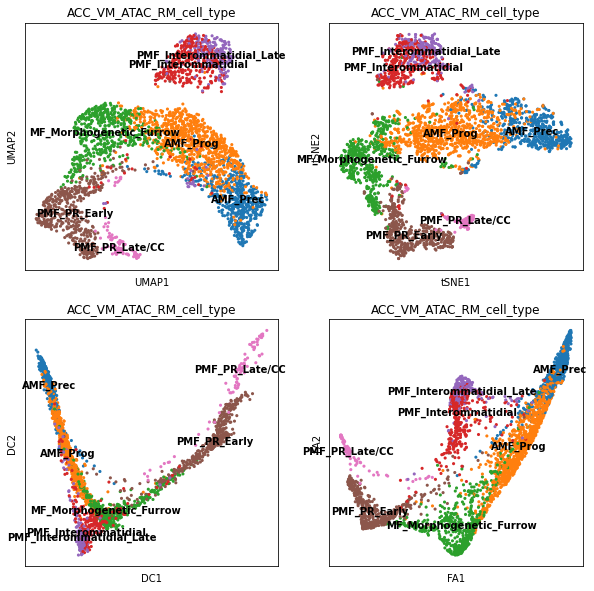

In [10]:
# Visualize
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1_dict = sc.pl.umap(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.tsne(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax2, show=False)
ax3_dict = sc.pl.diffmap(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax3, show=False)
ax4_dict = sc.pl.draw_graph(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax4, show=False)

Since here we have a branched trajectory, we can use PAGA to identify the branching point:

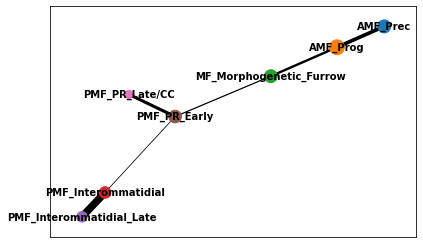

In [11]:
# Run PAGA
sc.tl.paga(adata, groups='ACC_VM_ATAC_RM_cell_type')
%matplotlib inline
sc.pl.paga(adata, threshold=0.1, color='ACC_VM_ATAC_RM_cell_type')

We can also refine our UMAP representation using the PAGA graph to initialize it:

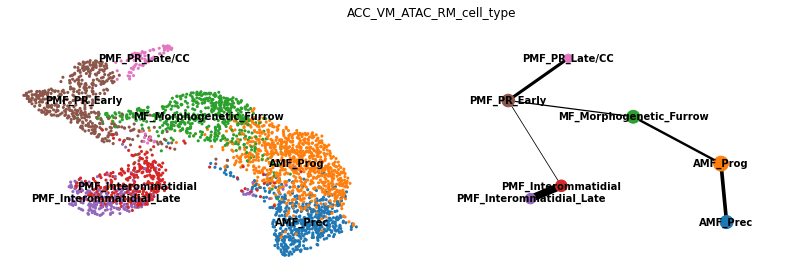

In [11]:
# Redo UMAP using PAGA map
sc.tl.umap(adata, init_pos='paga')
# Visualize. We see that paths split in PR_Early, but this is not true, it is due to the broad definition of cell types (it should be somewhere between MF and PR/INT)
sc.tl.paga(adata, groups='ACC_VM_ATAC_RM_cell_type')
sc.pl.paga_compare(adata, basis='umap', threshold=0.1)

In [17]:
adata.obs.drop('ACC_Predicted_doublets_fragments', axis=1, inplace=True)
adata.write_h5ad(outDir+'EAD.h5ad')

### 1c. Refine annotations (optional)

We notice that PAGA predicts the branching point on early photoreceptors. Based on literature, we expect it to be between the mofphogenitc furrow and interommatidial/photorecptors. We will refine the annotation for a better resolution of the differention groups:

In [23]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'EAD.h5ad')

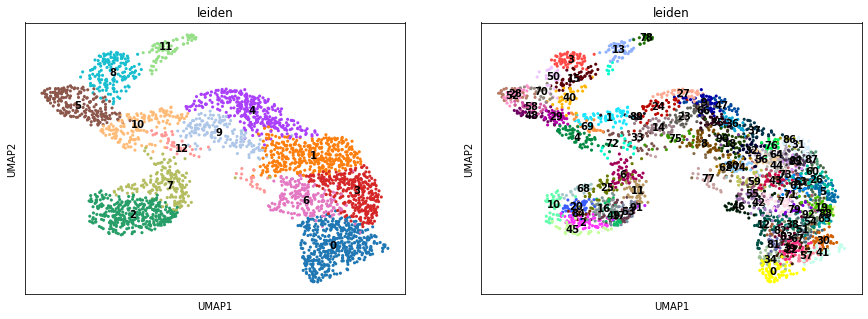

In [24]:
# Rename the division point as SMW.
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
sc.tl.leiden(adata, resolution=1)
ax1_dict = sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=ax1, show=False)
sc.tl.leiden(adata, resolution=10)
ax2_dict = sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=ax2, show=False)

In [25]:
# Broader annotation
sc.tl.leiden(adata, resolution=1)
adata.obs['Diff_state'] = adata.obs['leiden'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '0','Diff_state'] = 'AMF_Prog'
adata.obs.loc[adata.obs['leiden'] == '3','Diff_state'] = 'AMF_Prog'
adata.obs.loc[adata.obs['leiden'] == '6','Diff_state'] = 'AMF_Prog'
adata.obs.loc[adata.obs['leiden'] == '1','Diff_state'] = 'AMF_Prec'
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '4','Diff_state'] = 'MF_Morphogenetic_Furrow'
adata.obs.loc[adata.obs['leiden'] == '9','Diff_state'] = 'MF_Morphogenetic_Furrow'
adata.obs.loc[adata.obs['leiden'] == '12','Diff_state'] = 'MF_Morphogenetic_Furrow'
adata.obs.loc[adata.obs['leiden'] == '5','Diff_state'] = 'PMF_PR_Early'
adata.obs.loc[adata.obs['leiden'] == '8','Diff_state'] = 'PMF_PR_Intermediate'
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state'] = 'PMF_PR_Late'
adata.obs.loc[adata.obs['leiden'] == '7','Diff_state'] = 'PMF_Interommatidial'
adata.obs.loc[adata.obs['leiden'] == '2','Diff_state'] = 'PMF_Interommatidial_Late'
# Refine
sc.tl.leiden(adata, resolution=10)
adata.obs['Diff_state'] = adata.obs['Diff_state'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '1','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '72','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '33','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '77','Diff_state'] = 'AMF_Prec'
adata.obs.loc[adata.obs['leiden'] == '46','Diff_state'] = 'AMF_Prog'
sc.tl.leiden(adata, resolution=1)
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state'] = 'PMF_PR_Late'
# Subdividing SMW for PR and INT
sc.tl.leiden(adata, resolution=1)
adata.obs['Diff_state_refined'] = adata.obs['Diff_state'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state_refined'] = 'SMW_PR'
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state_refined'] = 'PMF_PR_Late'
sc.tl.leiden(adata, resolution=10)
adata.obs['Diff_state_refined'] = adata.obs['Diff_state_refined'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '1','Diff_state_refined'] = 'SMW_PR'
adata.obs.loc[adata.obs['leiden'] == '72','Diff_state_refined'] = 'SMW_INT'
adata.obs.loc[adata.obs['leiden'] == '33','Diff_state_refined'] = 'SMW_INT'
adata.obs.loc[adata.obs['leiden'] == '77','Diff_state_refined'] = 'AMF_Prec'
adata.obs.loc[adata.obs['leiden'] == '46','Diff_state_refined'] = 'AMF_Prog'
sc.tl.leiden(adata, resolution=1)
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state_refined'] = 'PMF_PR_Late'

We name the bifurcation point as Second Mitotic Wave based on cell cycle marker gene expression in some of the cells. This is an optional mitotic division that cells can go on right after the morphogenetic furrow before differentiating to photorecptor or interommatidial cells. Let's rerun PAGA with these redefined groups:

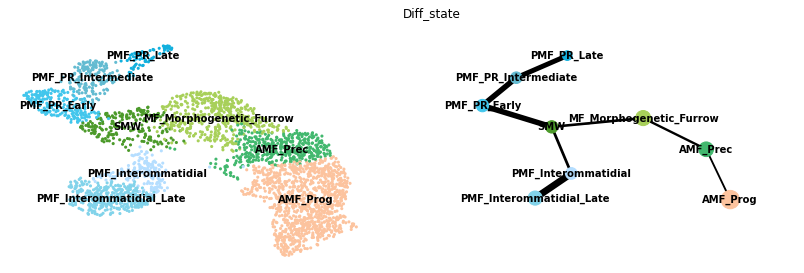

In [26]:
# PAGA graph with broad annotation.
sc.tl.paga(adata, groups='Diff_state')
sc.pl.paga_compare(adata, basis='umap', threshold=0.245, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
})

In [27]:
adata.write_h5ad(outDir+'EAD.h5ad')

### 1d. Add gene expression

We will add gene expression values to the annData object. This is useful to easily query TF or target genes expression as well:

In [50]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'EAD.h5ad')

In [51]:
import pandas as pd
import anndata
import sklearn
adata_gene = anndata.AnnData(X=scplus_obj.to_df('EXP').copy())
sc.pp.normalize_total(adata_gene, target_sum=1e4)
sc.pp.log1p(adata_gene)
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
adata_all = ad.concat([adata, adata_gene], axis=1, merge='unique', uns_merge='unique').copy()

In [52]:
adata.write_h5ad(outDir+'EAD.h5ad')

### 1e. Add embedding-based pseudotime

To be able to identify the differentiation arrows, we need to get a pseudotime that represents the differentiation order. We can use the `get_embedding_dpt` function for this: 

In [33]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'EAD.h5ad')

/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


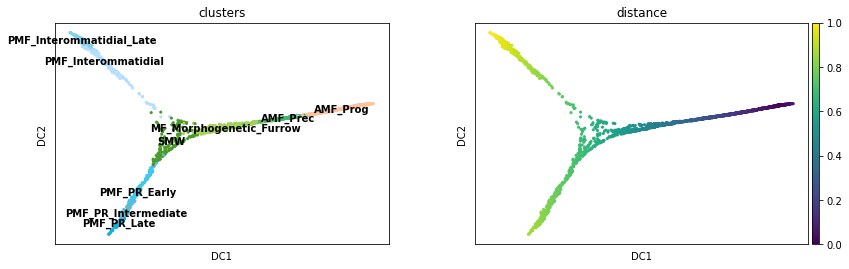

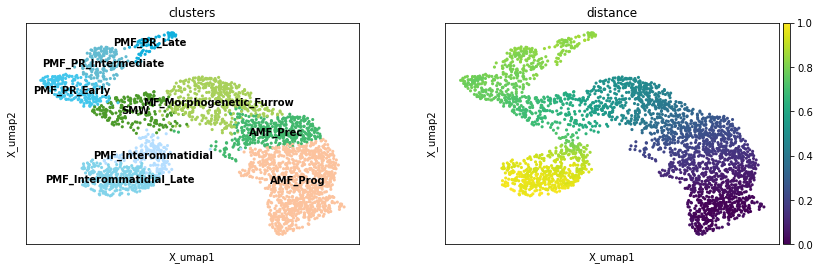

In [37]:
# Choose the embedding you want to plot arrows in. 
# The function will already save the annotations as clusters and distance, which are require for downstream steps.
from scenicplus.differentiation_potential import *
get_embedding_dpt(adata, 'Diff_state', 'AMF_Prog', embedding_key='X_umap', n_dcs=2, figsize=(12,8), palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
})

In [38]:
# Save
adata.write_h5ad(outDir+'EAD.h5ad')

## 2. Inferring differentiation arrows

Next, we need to identify the changes in TF expression, target regions accessibility and target gene expression along the different paths using the `get_path_matrix` function. For this we have to specify the paths and the cell types involved, in this case one from progenitors to photoreceptirs and another from progenitors to interommatidial cells:

In [53]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'EAD.h5ad')

In [54]:
# Set paths
paths = [('PR', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_PR', 'PMF_PR_Early', 'PMF_PR_Intermediate', 'PMF_PR_Late']),
         ('INT', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_INT', 'PMF_Interommatidial', 'PMF_Interommatidial_Late'])]

In [55]:
# Calculate path matrices
## Select path features
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
from scenicplus.differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'Diff_state_refined',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

Before plotting the differentiation arrows, we can check how TF expression, target regions accessibility and target gene expression change along the differentiation branches. By default, we fit a standarized GAM model for each of the measurements:

With the `plot_map` function we can plot the differentiation arrows in the embedding. There are some important parameters here:

* **tf_exp_thr**: This is the minimal TF expression quatile to draw arrows from a cell. 
* **tf_traj_thr**: This is the minimal TF expression quatile to draw arrows from a cell within the branch (if only one branch, this is equivalent to `tf_expr_thr`.
* **penalization**: Minimum distance between the penalization curve and the trajetory curve to draw an arrow from the cell. In the plots below the global standarized curve is drawn as a dashed grey line. 

Briefly, we first order the differentiating cells by pseudotime. For each TF, we fit a standardized generalized additive model (GAM) along the pseudotime axis for its expression and its target genes (or regions) AUC values, using pyGAM (v0.8.0). We then map each cell in a certain quantile of the GAM TF expression model with the one in the same quantile in the GAM regulon AUC curve (posterior in the pseudotime axis). If there is no posterior cell in that quantile, the cell is mapped to itself. We define the differentiation force of a cell as the distance from the TF expression curve to its matching cell in the regulon AUC curve. When having multiple differentiation paths, we apply the same strategy in each path, and then average the two (or more) arrows available for cells found in more than one path. In addition, since we standardize the data prior to fitting the GAM model, we introduce a penalization curve standardized on the whole data set. This will prevent that if a TF (or its target) are not present in the branch, false arrows will not be drawn if the TF is not expressed compared to the rest of the data set. Differentiation forces can be plotted as an arrow grid in any dimensionality reduction of the data and prioritized per group of cells to identify key drivers in differentiation transitions. To visualize a regulon differentiation force, the distance in the embedding between matching cells is calculated (delta embedding).

Lozenge (Lz) is a key TF in interommatidial cell differentiation, and it is not expected to drive the diffenrentiation of cells in the photoreceptor branch. Since we standardized our GAM models, if we look in the PR branch we see some changes; however, when we compared it with the global standardized GAM model we see that the lines do not match, and the distance is larger than the penalization. Using this approach will prevent us from drawing false arrows that can arise due to low expression of the TF in some cells in the branch (that will be standardize to one), even if the TF is actually mostly expressed in the other branch.

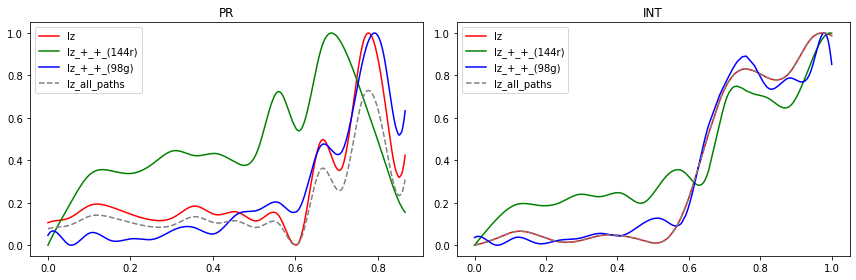

In [56]:
# Plot changes along trajectory
#import os
#os.mkdir(outDir+'/curve_plots/')
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'lz', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'lz', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig(outDir+'curve_plots/lz.pdf')

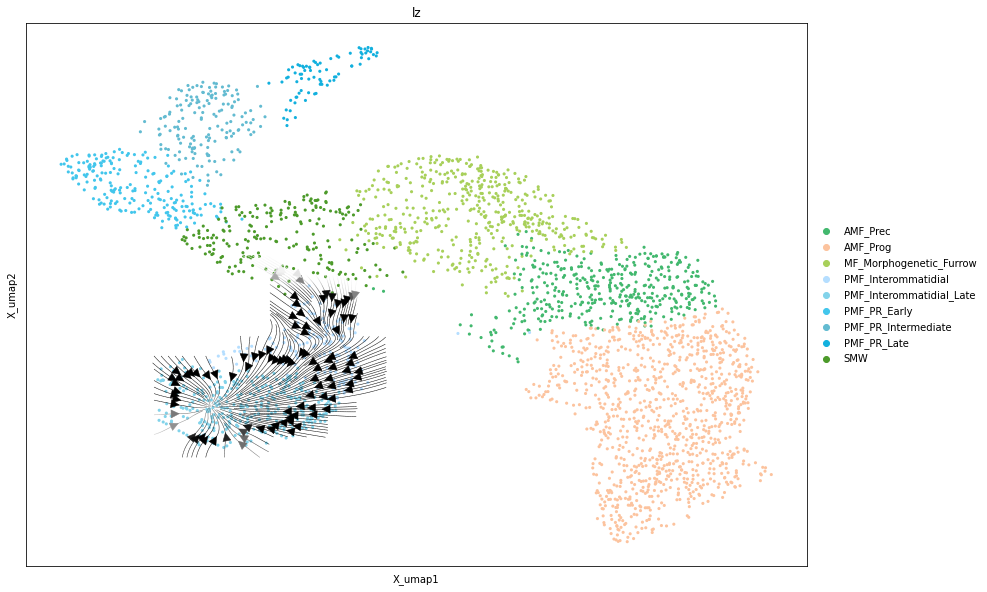

In [57]:
os.mkdir(outDir+'/arrow_plots/')
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'lz', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save=outDir+'arrow_plots/lz+.pdf')

We will show to additional examples below, for Optix, Ato, Sens, Gl and Lola. Note that when a cell appears in more than one branch, we average the arrows across branches:

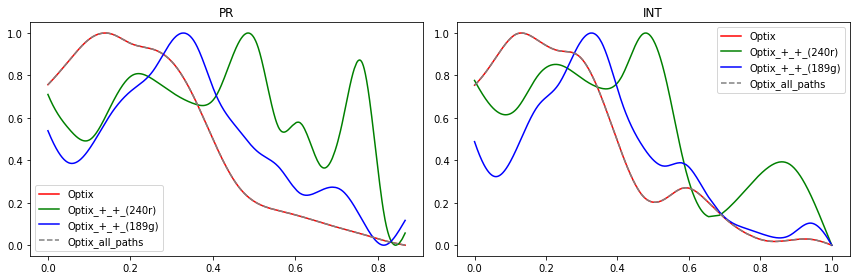

In [58]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'Optix', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'Optix', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig(outDir+'curve_plots/Optix.pdf')

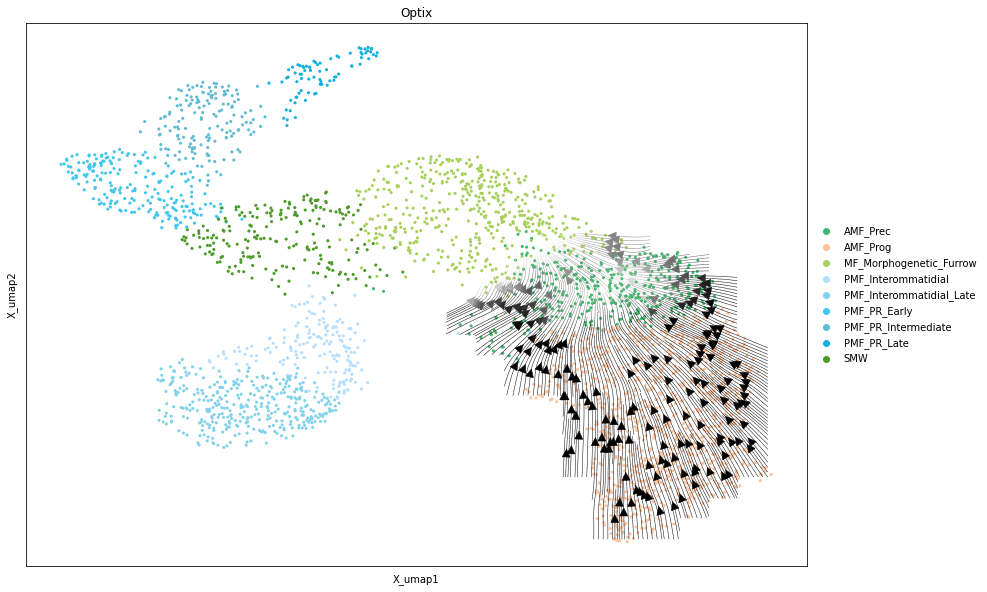

In [63]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Optix', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save=outDir+'arrow_plots/Optix_thr_low.pdf')

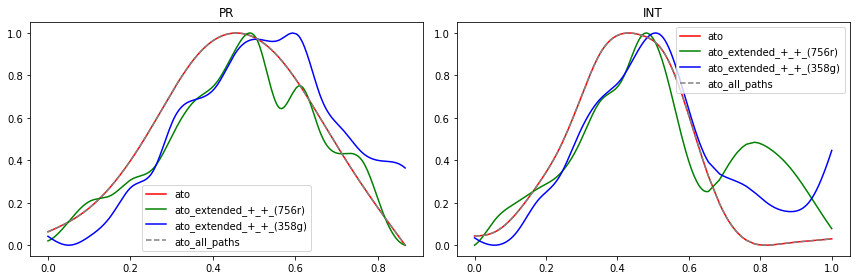

In [64]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'ato_extended', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'ato_extended', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig(outDir+'/curve_plots/ato.pdf')

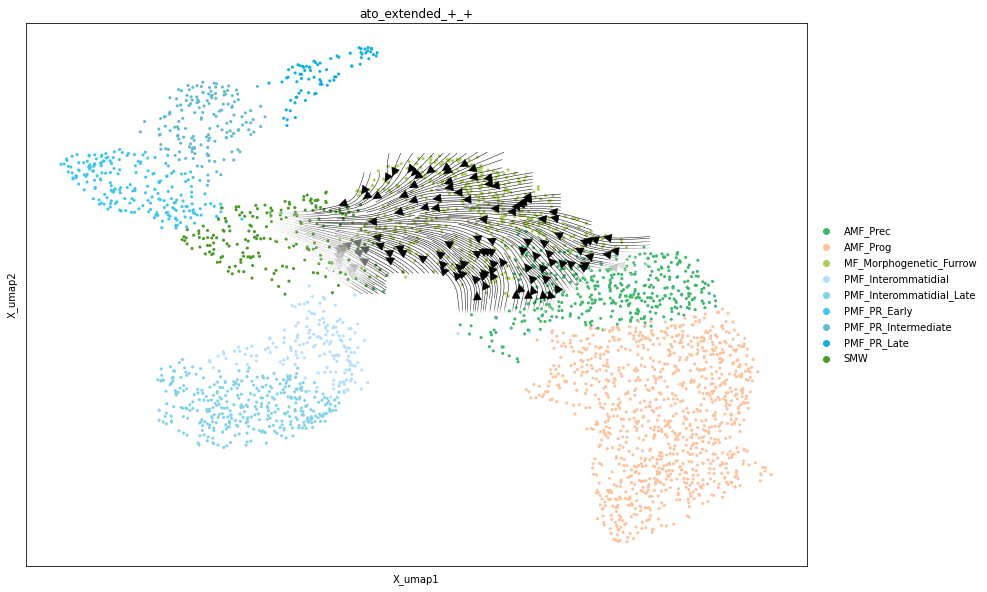

In [65]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'ato_extended_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, penalization=0.5,palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save=outDir+'arrow_plots/ato_+_+.pdf')

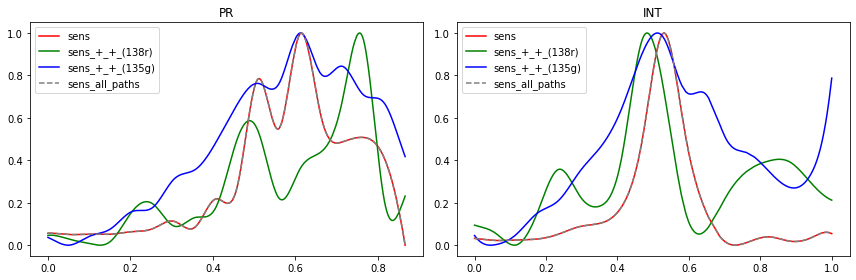

In [66]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'sens_+_+', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'sens_+_+', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig(outDir+'curve_plots/sens.pdf')

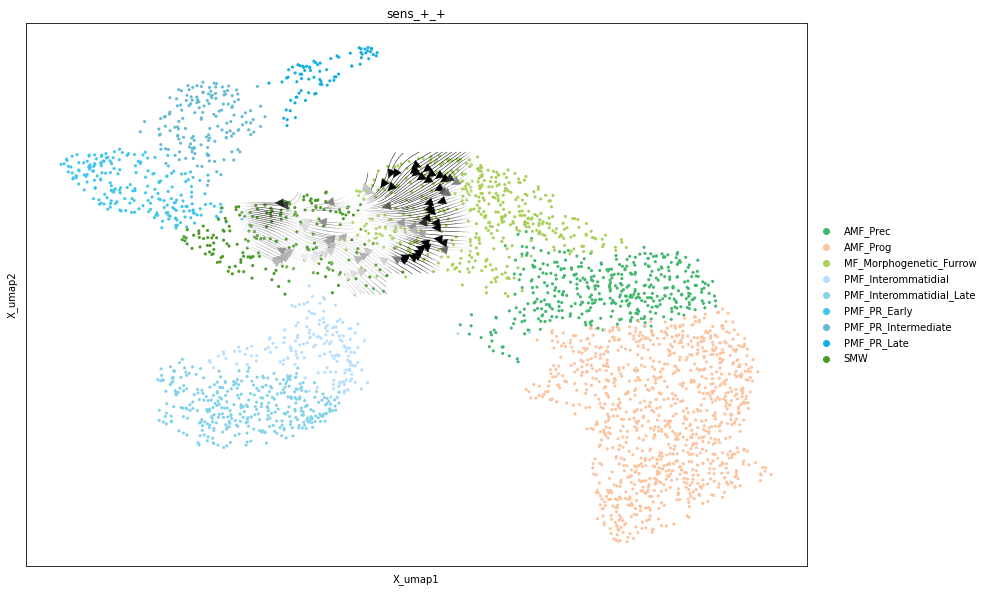

In [67]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'sens_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save=outDir+'arrow_plots/sens.pdf')

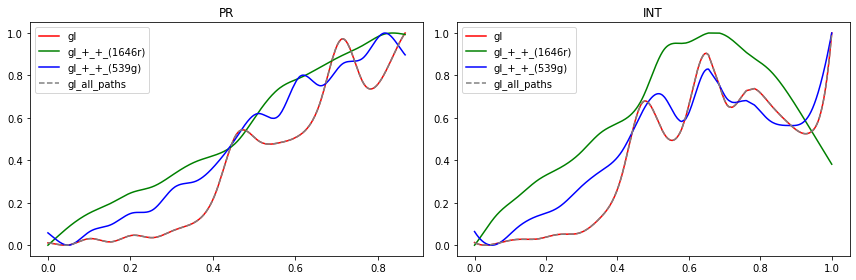

In [68]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'gl', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'gl', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig(outDir+'/curve_plots/gl.pdf')

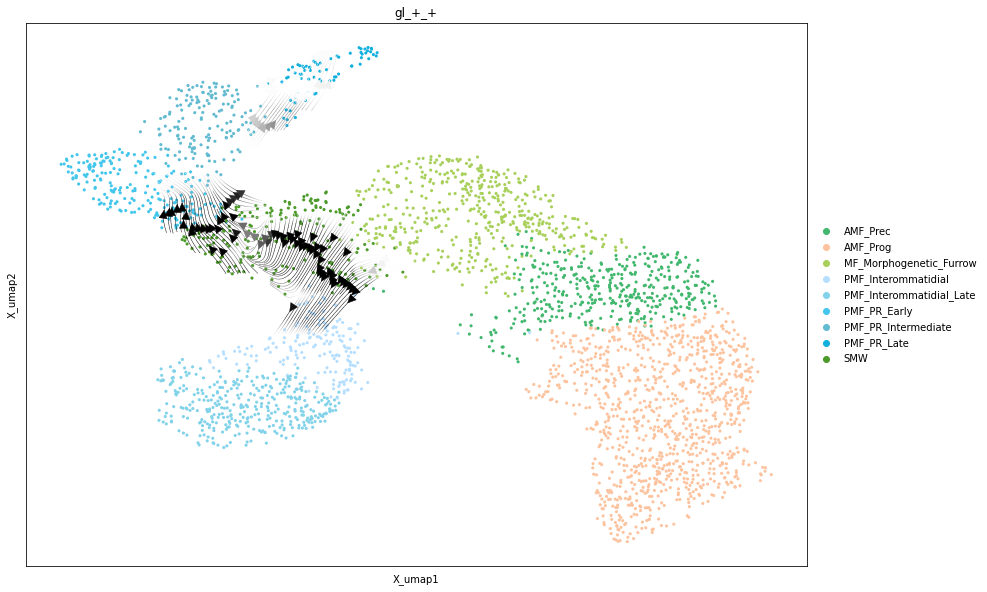

In [69]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'gl_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, penalization=0.5,palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save=outDir+'/arrow_plots/gl_+_+.pdf')

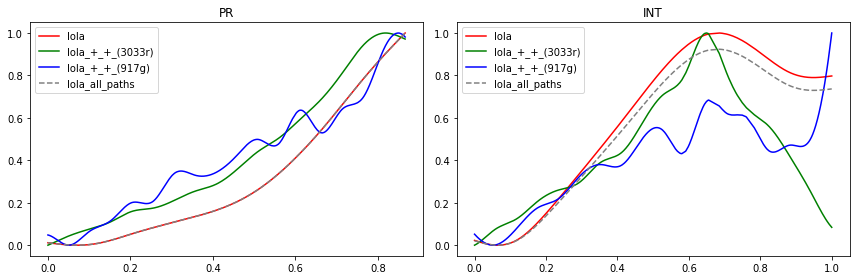

In [70]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'lola', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'lola', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig(outDir+'/curve_plots/lola.pdf')

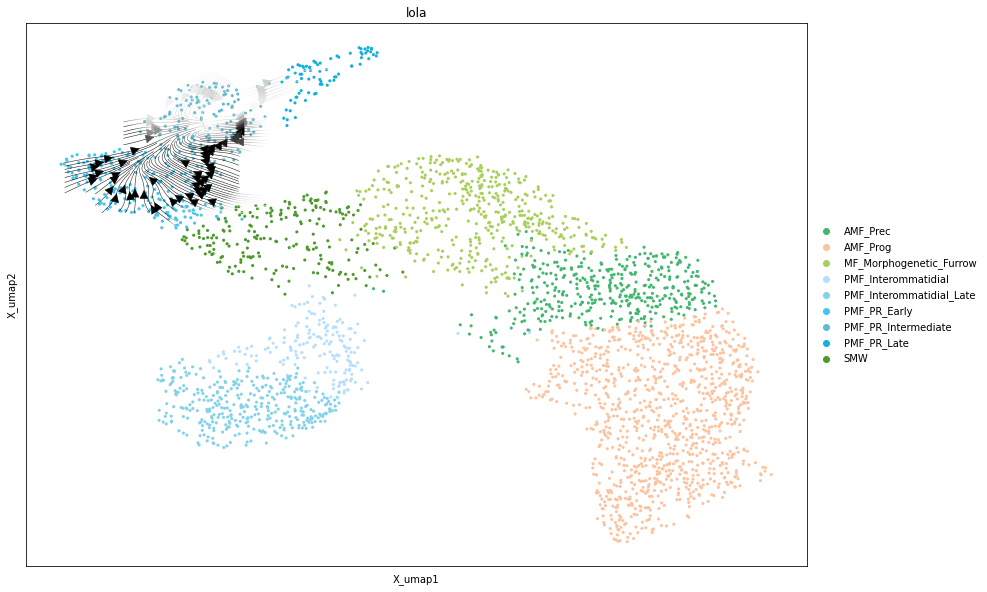

In [71]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'lola', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save=outDir+'arrow_plots/lola.pdf')

## 3. Calculate the most relevant forces for a cell

### 3a. Calculate forces per cell

We can also prioritize differentiation forces along the trajectory. For that, we can use the `cell_forces` function, which will compute arrows for each cell and regulon, returning a matrix with the lengths of the arrows for each cell (the differentiation force).

In [72]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'EAD.h5ad')

In [73]:
# Set paths
paths = [('PR', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_PR', 'PMF_PR_Early', 'PMF_PR_Intermediate', 'PMF_PR_Late']),
         ('INT', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_INT', 'PMF_Interommatidial', 'PMF_Interommatidial_Late'])]

In [74]:
# Calculate path matrices
## Select path features
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
from scenicplus.differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'Diff_state_refined',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [75]:
# We will do only for the positives as example
ke = list(paths_cascade[list(paths_cascade.keys())[0]].keys())
selected_eGRNs = [x.split('_(')[0] for x in paths_cascade['Gene'][ke[0]].columns if '+_+' in x]
len(selected_eGRNs)

400

In [ ]:
# Get differentiation forces (~10 min)
import time
start_time = time.time()
df = cell_forces(adata, paths_cascade, plot_type='tf_to_gene', window=1, gam_smooth=True, tf_traj_thr=0.7, tf_expr_thr=0.2,
               selected_eGRNs=selected_eGRNs, n_cpu=20, _temp_dir='/scratch/leuven/313/vsc31305/ray_spill')
print(time.time() - start_time)
#~10 min

In [10]:
# Save
import dill
with open(outDir+'cell_forces.pkl', 'wb') as f:
    dill.dump(df, f)

### 3b. Get RSS

As done with the regulon AUC values, we can use the RSS function to prioritize the cell forces per cell (or group of cells). As an example, we will use the cell type labels, but you can also bin the trajectory for better resolution:

In [1]:
# Load
import dill
infile = open(outDir+'cell_forces.pkl', 'rb')
df = dill.load(infile)
infile.close()

In [9]:
# We will ll filter lowly expressed TFs in this branch
import numpy as np
adata.var['Score'] = np.count_nonzero(adata.X > 1.5, axis=0)
# We will keep only high quality regulons
import pandas as pd
subset = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/HQ_regulons_only_eye.tsv').iloc[:,0].tolist()
subset = [x.split('_')[0] for x in subset]
s = [x.split('_(')[0] for x in selected_features['Gene'] if '+_+' in x and x.split('_')[0] in subset and x.split('_(')[0] in df.columns and adata.var['Score'].loc[x.split('_')[0]] > 30]

In [16]:
# Calculate RSS and keep extended only if not direct
rss_values = forces_rss(adata, df, 'Diff_state_refined')
direct_eRegulons = [x for x in rss_values.columns if not 'extended' in x]
extended_eRegulons =  [x for x in rss_values.columns  if 'extended' in x and not x.replace('_extended', '') in direct_eRegulons]
selected_eRegulons = direct_eRegulons + extended_eRegulons
import re
rss_values= rss_values[selected_eRegulons]
rss_values.columns = [re.sub('_extended', '', file) for file in rss_values.columns]

In [17]:
# Optional: Select regulons to plot
selected_eRegulons = ['h', 'Optix', 'toy', 'ey', 'aop', 'sens', 'ato', 'E(spl)mgamma-HLH', 'E(spl)m5-HLH', 'rn', 'lola', 'luna', 'ase', 'gl', 'so', 'l(3)neo38', 'ro', 'salm', 'Pph13', 'bru3', 'nerfin-1', 'svp', 'run', 'chinmo', 'onecut',
                      'retn', 'sv', 'scrt', 'ewg', 'pros', 'mamo', 'lz', 'B-H1', 'B-H2', 'ttk']
selected_eRegulons = [x+'_+_+' for x in selected_eRegulons]
rss_values= rss_values[selected_eRegulons]
rss_values.columns = [re.sub('_\+_\+', '(+)', file) for file in rss_values.columns]

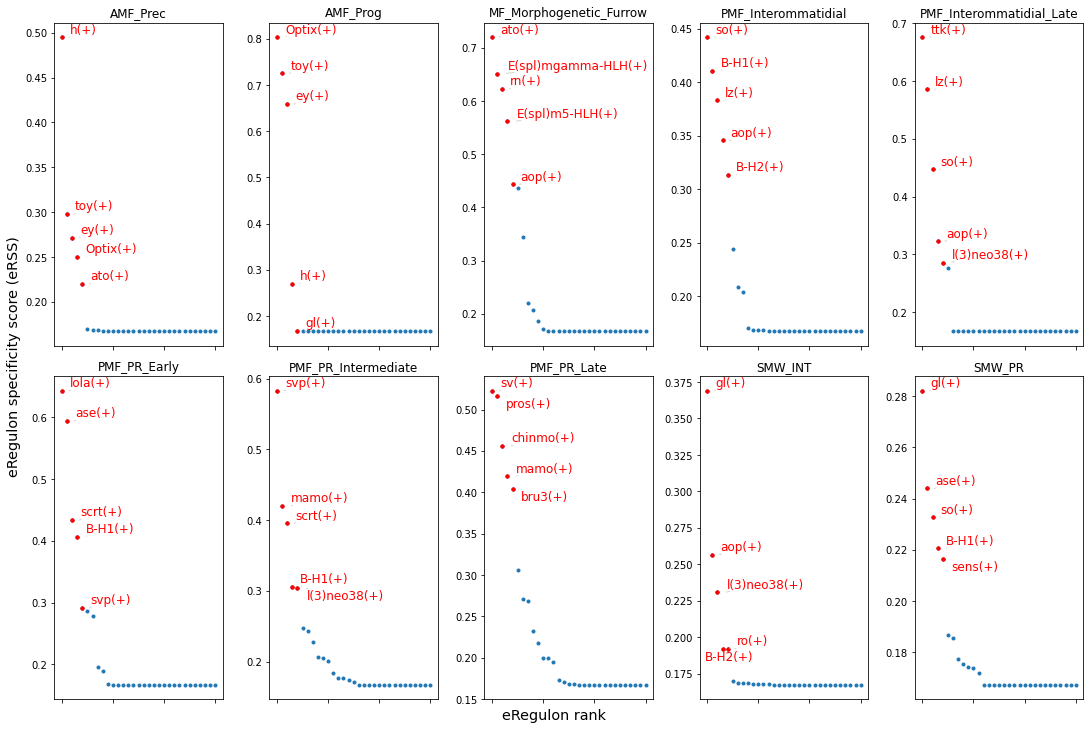

In [25]:
plot_forces_rss(rss_values_2, top_n=5, num_columns=5,  save=outDir+'prior_rss.pdf', figsize = (15, 10))